In [8]:
import tensorflow as tf
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from tqdm import tqdm

class UAutoRec():
    def __init__(self, sess, num_user, num_item, learning_rate=0.001, reg_rate=0.1, epoch=20, batch_size=200,
                 verbose=False, T=3, display_step=1000):
        self.learning_rate = learning_rate
        self.epochs = epoch
        self.batch_size = batch_size
        self.reg_rate = reg_rate
        self.sess = sess
        self.num_user = num_user
        self.num_item = num_item
        self.verbose = verbose
        self.T = T
        self.display_step = display_step
        print("UAutoRec with Confounder and Exposure.")

    def build_network(self, hidden_neuron=500):
        self.rating_matrix = tf.compat.v1.placeholder(dtype=tf.float32, shape=[self.num_item, None])
        self.rating_matrix_mask = tf.compat.v1.placeholder(dtype=tf.float32, shape=[self.num_item, None])
        self.confounder_matrix = tf.compat.v1.placeholder(dtype=tf.float32, shape=[self.num_item, None])
        self.exposure_matrix = tf.compat.v1.placeholder(dtype=tf.float32, shape=[self.num_item, None])

        # Rating path
        V_R = tf.Variable(tf.random.normal([hidden_neuron, self.num_item], stddev=0.01))
        mu_R = tf.Variable(tf.random.normal([hidden_neuron], stddev=0.01))
        layer_1_R = tf.sigmoid(tf.expand_dims(mu_R, 1) + tf.matmul(V_R, self.rating_matrix))
        
        # Confounder path
        V_C = tf.Variable(tf.random.normal([hidden_neuron, self.num_item], stddev=0.01))
        mu_C = tf.Variable(tf.random.normal([hidden_neuron], stddev=0.01))
        layer_1_C = tf.sigmoid(tf.expand_dims(mu_C, 1) + tf.matmul(V_C, self.confounder_matrix))
        
        # Exposure path
        V_E = tf.Variable(tf.random.normal([hidden_neuron, self.num_item], stddev=0.01))
        mu_E = tf.Variable(tf.random.normal([hidden_neuron], stddev=0.01))
        layer_1_E = tf.sigmoid(tf.expand_dims(mu_E, 1) + tf.matmul(V_E, self.exposure_matrix))
        
        # Combine paths
        layer_1 = layer_1_R + layer_1_C + layer_1_E
        
        # Output layer
        W = tf.Variable(tf.random.normal([self.num_item, hidden_neuron], stddev=0.01))
        b = tf.Variable(tf.random.normal([self.num_item], stddev=0.01))
        self.layer_2 = tf.matmul(W, layer_1) + tf.expand_dims(b, 1)
        self.loss = tf.reduce_mean(tf.square(
            tf.norm(tf.multiply((self.rating_matrix - self.layer_2), self.rating_matrix_mask)))) + self.reg_rate * (
        tf.square(tf.norm(W)) + tf.square(tf.norm(V_R)) + tf.square(tf.norm(V_C)) + tf.square(tf.norm(V_E)))
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.loss)

    def train(self, train_data, confounder_data, exposure_data):
        self.num_training = self.num_user
        total_batch = int(self.num_training / self.batch_size)
        idxs = np.random.permutation(self.num_training)  # shuffled ordering

        total_loss = 0
        for i in range(total_batch):
            start_time = time.time()
            if i == total_batch - 1:
                batch_set_idx = idxs[i * self.batch_size:]
            elif i < total_batch - 1:
                batch_set_idx = idxs[i * self.batch_size: (i + 1) * self.batch_size]

            try:
                _, loss = self.sess.run([self.optimizer, self.loss],
                                        feed_dict={self.rating_matrix: self.train_data[:, batch_set_idx],
                                                   self.rating_matrix_mask: self.train_data_mask[:, batch_set_idx],
                                                   self.confounder_matrix: confounder_data[:, batch_set_idx],
                                                   self.exposure_matrix: exposure_data[:, batch_set_idx]})
                total_loss += loss
            except IndexError as e:
                print(f"IndexError: {e}")
                print(f"Max index in batch_set_idx: {max(batch_set_idx)}")
                print(f"Train data shape: {self.train_data.shape}")
                print(f"Confounder data shape: {confounder_data.shape}")
                raise

        return total_loss / total_batch

    def test(self, test_data, confounder_data, exposure_data):
        self.reconstruction = self.sess.run(self.layer_2, feed_dict={self.rating_matrix: self.train_data,
                                                                     self.rating_matrix_mask: self.train_data_mask,
                                                                     self.confounder_matrix: confounder_data,
                                                                     self.exposure_matrix: exposure_data})
        error = 0
        error_mae = 0
        test_set = list(test_data.keys())
        for (u, i) in test_set:
            pred_rating_test = self.predict(u, i)
            error += (float(test_data.get((u, i))) - pred_rating_test) ** 2
            error_mae += (np.abs(float(test_data.get((u, i))) - pred_rating_test))
        rmse = RMSE(error, len(test_set))
        mae = MAE(error_mae, len(test_set))
        return rmse, mae

    def execute(self, train_data, test_data, confounder_data, exposure_data):
        self.train_data = self._data_process(train_data.transpose())
        self.train_data_mask = np.sign(self.train_data)
        print(f"Train data processed shape: {self.train_data.shape}")
        print(f"Confounder data shape: {confounder_data.shape}")
        init = tf.compat.v1.global_variables_initializer()
        self.sess.run(init)

        with tqdm(total=self.epochs, desc="Training", unit="epoch") as pbar:
            for epoch in range(self.epochs):
                avg_loss = self.train(train_data, confounder_data, exposure_data)
                if (epoch) % self.T == 0:
                    rmse, mae = self.test(test_data, confounder_data, exposure_data)
                    pbar.set_postfix({"Loss": avg_loss, "RMSE": rmse, "MAE": mae})
                pbar.update(1)

    def save(self, path):
        saver = tf.compat.v1.train.Saver()
        saver.save(self.sess, path)

    def predict(self, user_id, item_id):
        if user_id >= self.num_user or item_id >= self.num_item:
            raise IndexError("user_id or item_id out of bounds")
        return self.reconstruction[item_id, user_id]

    def _data_process(self, data):
        output = np.zeros((self.num_item, self.num_user))
        for u in range(self.num_user):
            for i in range(self.num_item):
                output[i, u] = data.get((i, u), 0)  # Use .get() with a default value of 0
        return output

def RMSE(error, num):
    return np.sqrt(error / num)

def MAE(error_mae, num):
    return (error_mae / num)

def load_data_rating(train_file, test_file, columns=[0, 1, 2], sep="\t"):
    tr_vd_dat = pd.read_csv(train_file, sep=sep, header=None, names=['userId', 'itemId', 'rating'], usecols=columns, engine="python")
    train_data, vd_data =  train_test_split(tr_vd_dat, test_size=0.2, random_state=42)#pd.read_csv(train_file, sep=sep, header=None, names=['userId', 'itemId', 'rating'], usecols=columns, engine="python")
    test_data = pd.read_csv(test_file, sep=sep, header=None, names=['userId', 'itemId', 'rating'], usecols=columns, engine="python")

    n_users = max(train_data['userId'].max(), test_data['userId'].max()) + 1
    n_items = max(train_data['itemId'].max(), test_data['itemId'].max()) + 1

    train_row = []
    train_col = []
    train_rating = []

    for line in train_data.itertuples():
        u = line[1]
        i = line[2]
        train_row.append(u)
        train_col.append(i)
        train_rating.append(line[3])

    train_matrix = csr_matrix((train_rating, (train_row, train_col)), shape=(n_users, n_items))

    test_row = []
    test_col = []
    test_rating = []
    for line in test_data.itertuples():
        u = line[1]
        i = line[2]
        test_row.append(u)
        test_col.append(i)
        test_rating.append(line[3])

    test_matrix = csr_matrix((test_rating, (test_row, test_col)), shape=(n_users, n_items))

    vd_row = []
    vd_col = []
    vd_rating = []
    for line in vd_data.itertuples():
        u = line[1]
        i = line[2]
        vd_row.append(u)
        vd_col.append(i)
        vd_rating.append(line[3])

    vd_matrix = csr_matrix((vd_rating, (vd_row,vd_col)), shape=(n_users, n_items))

    print("Load data finished. Number of users:", n_users, "Number of items:", n_items)
    return train_matrix.todok(), test_matrix.todok(), vd_matrix.todok(), n_users, n_items

# Example usage
file1 = 'C:/Users/Sten Stokroos/Desktop/Thesis2.0/zelf/neural_collaborative_filtering/Data/ml-1m.train.rating'  # Replace with the actual file path
file2 = 'C:/Users/Sten Stokroos/Desktop/Thesis2.0/zelf/neural_collaborative_filtering/Data/ml-1m.test.rating' # Replace with the actual file path
# combined_df = load_and_combine_data(file1, file2, columns=[0, 1, 2], sep="\t")

# combined_df.to_csv('C:/Users/Sten Stokroos/Desktop/Thesis2.0/zelf/neural_collaborative_filtering/Data/ml-1m.csv', index = False)



train, test, vad, user, item = load_data_rating(file1, file2, columns=[0, 1, 2], sep="\t")



CAUSEFIT_DIR = 'C:/Users/Sten Stokroos/Desktop/Thesis2.0/zelf/xposure_matrix.csv'

conf_df = pd.read_csv(CAUSEFIT_DIR, header=None)

# Convert the DataFrame to a NumPy array
confounder_data = conf_df.to_numpy()
confounder_data = confounder_data.T

# dim = 30 
# U = np.loadtxt(CAUSEFIT_DIR + '/cause_pmf_k'+str(dim)+'_U.csv')
# B = np.loadtxt(CAUSEFIT_DIR + '/cause_pmf_k'+str(dim)+'_V.csv')
# U = np.atleast_2d(U.T).T
# B = np.atleast_2d(B.T).T
# confounder_data = (U.dot(B.T)).T

# #MLP OPtion
# df = pd.read_csv('C:/Users/Sten Stokroos/Desktop/Thesis2.0/zelf/neural_collaborative_filtering/Data/predicted_scores_copy.csv')
# confounder_data = df.to_numpy()
# # Transpose the array if needed
# confounder_data = confounder_data.T



# # Create the exposure data matrix
exposure_data = (train > 0).astype(np.float32).todense().T

# # Set TensorFlow session
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True

# with tf.compat.v1.Session(config=config) as sess:
#     model = UAutoRec(sess, user, item, learning_rate=0.001, reg_rate=0.1, epoch=20, batch_size=500, verbose=True)
#     model.build_network()
#     model.execute(train, test, confounder_data, exposure_data)



# 20/20 [01:15<00:00,  3.79s/epoch, Loss=5.98e+4, RMSE=0.91, MAE=0.721] YES BABYYYYY MLP

# 3.16s/epoch, Loss=6.76e+4, RMSE=0.976, MAE=0.778] HPF and test.rating everywehre




Load data finished. Number of users: 6040 Number of items: 3706


In [9]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True


def objective(params):
    learning_rate = params['learning_rate']
    reg_rate = params['reg_rate']
    hidden_neuron = params['hidden_neuron']
    batch_size = params['batch_size']

    with tf.compat.v1.Session(config=config) as sess:
        model = UAutoRec(sess, user, item, learning_rate=learning_rate, reg_rate=reg_rate, epoch=20, batch_size=batch_size, verbose=True)
        model.build_network(hidden_neuron=hidden_neuron)
        model.execute(train, vad, confounder_data, exposure_data)
        
        # Evaluate the model on the validation set
        rmse, mae = model.test(vad, confounder_data, exposure_data)
        return {'loss': rmse, 'status': STATUS_OK}


space = {
    'learning_rate': hp.uniform('learning_rate', 0.0001, 0.01),
    'reg_rate': hp.uniform('reg_rate', 0.0001, 0.01),
    'hidden_neuron': hp.choice('hidden_neuron', [100, 250, 500]),
    'batch_size': hp.choice('batch_size', [100, 200, 400])
}

# Run Hyperopt
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=5, trials=trials)



print("Best parameters:", best)

best_params = {
    'learning_rate': best['learning_rate'],
    'reg_rate': best['reg_rate'],
    'hidden_neuron': [100, 200, 500][best['hidden_neuron']],
    'batch_size': [100, 200, 500][best['batch_size']]
}



# Train the final model on the entire training data
with tf.compat.v1.Session(config=config) as sess:
    final_model = UAutoRec(sess, user, item, learning_rate=best_params['learning_rate'], reg_rate=best_params['reg_rate'], epoch =20 , batch_size=best_params['batch_size'], verbose=True) #learning_rate= 0.001, reg_rate= 0.1, epoch = 20, batch_size= 200, verbose= True) 
    final_model.build_network(hidden_neuron= best_params['hidden_neuron'])
    final_model.execute(train, test, confounder_data, exposure_data)

    # Evaluate the final model on the test set
    final_rmse, final_mae = final_model.test(test, confounder_data, exposure_data)
    print(f"Final RMSE: {final_rmse}, Final MAE: {final_mae}")


UAutoRec with Confounder and Exposure.               
Train data processed shape: (3706, 6040)             
Confounder data shape: (3706, 6040)                  
  0%|          | 0/5 [01:50<?, ?trial/s, best loss=?]

Training: 100%|##########| 20/20 [01:45<00:00,  5.28s/epoch, Loss=8.87e+3, RMSE=0.883, MAE=0.696]


UAutoRec with Confounder and Exposure.                                          
Train data processed shape: (3706, 6040)                                        
Confounder data shape: (3706, 6040)                                             
 20%|██        | 1/5 [05:37<15:00, 225.14s/trial, best loss: 0.8821357059669697]

Training: 100%|##########| 20/20 [01:52<00:00,  5.61s/epoch, Loss=1.57e+4, RMSE=0.886, MAE=0.7]


UAutoRec with Confounder and Exposure.                                          
Train data processed shape: (3706, 6040)                                        
Confounder data shape: (3706, 6040)                                             
 40%|████      | 2/5 [09:31<11:31, 230.53s/trial, best loss: 0.8821357059669697]

Training: 100%|##########| 20/20 [01:44<00:00,  5.23s/epoch, Loss=8.4e+3, RMSE=0.903, MAE=0.71]


UAutoRec with Confounder and Exposure.                                          
Train data processed shape: (3706, 6040)                                        
Confounder data shape: (3706, 6040)                                             
 60%|██████    | 3/5 [13:17<07:36, 228.24s/trial, best loss: 0.8821357059669697]

Training: 100%|##########| 20/20 [01:58<00:00,  5.92s/epoch, Loss=3.71e+4, RMSE=0.901, MAE=0.71]


UAutoRec with Confounder and Exposure.                                          
Train data processed shape: (3706, 6040)                                        
Confounder data shape: (3706, 6040)                                             
 80%|████████  | 4/5 [17:20<03:52, 232.90s/trial, best loss: 0.8821357059669697]

Training: 100%|##########| 20/20 [01:48<00:00,  5.43s/epoch, Loss=8.25e+3, RMSE=0.897, MAE=0.708]


100%|██████████| 5/5 [19:19<00:00, 231.81s/trial, best loss: 0.8821357059669697]
Best parameters: {'batch_size': 0, 'hidden_neuron': 0, 'learning_rate': 0.003875985280353702, 'reg_rate': 0.007799886438220755}
UAutoRec with Confounder and Exposure.
Train data processed shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training: 100%|██████████| 20/20 [01:13<00:00,  3.68s/epoch, Loss=8.76e+3, RMSE=0.939, MAE=0.743]


Final RMSE: 0.9495851690621429, Final MAE: 0.7572326163286405


UAutoRec with Confounder and Exposure.
UAutoRec with Confounder and Exposure.
UAutoRec with Confounder and Exposure.
UAutoRec with Confounder and Exposure.
UAutoRec with Confounder and Exposure.
UAutoRec with Confounder and Exposure.
UAutoRec with Confounder and Exposure.


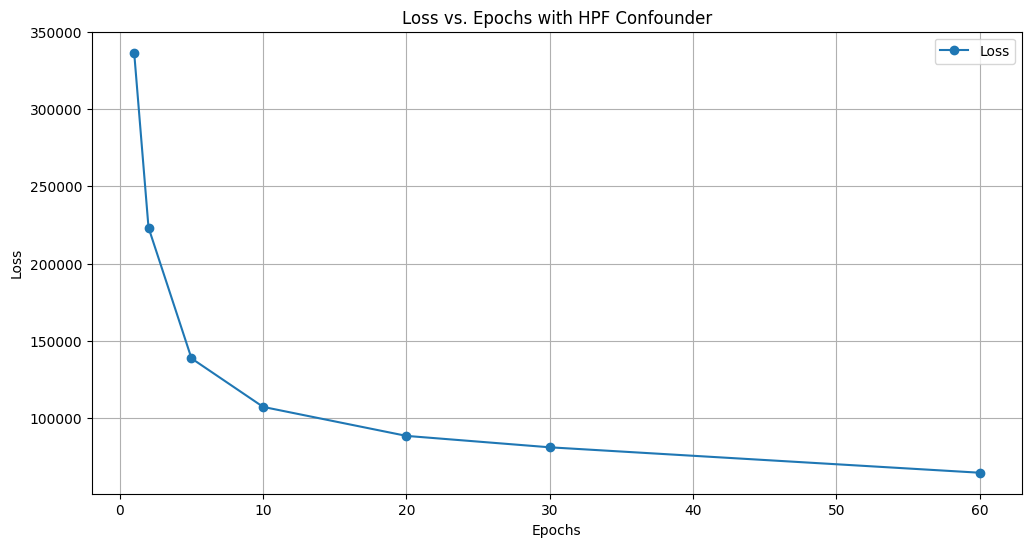

In [9]:


# Define the class and functions (assuming UAutoRec class is already defined
def experiment_epochs(epochs_range, train, test, confounder_type, exposure_data):
    loss_results = []

    for epochs in epochs_range:
        if confounder_type == 'HPF':
            U = np.loadtxt(CAUSEFIT_DIR + f'/cause_pmf_k{30}_U.csv')  # Use default dim for consistency
            B = np.loadtxt(CAUSEFIT_DIR + f'/cause_pmf_k{30}_V.csv')
            U = np.atleast_2d(U.T).T
            B = np.atleast_2d(B.T).T
            confounder_data = (U.dot(B.T)).T
        elif confounder_type == 'MLP':
            df = pd.read_csv('C:/Users/Sten Stokroos/Desktop/Thesis2.0/zelf/neural_collaborative_filtering/Data/predicted_scores_copy.csv')
            confounder_data = df.to_numpy()
            confounder_data = confounder_data.T

        with tf.compat.v1.Session(config=config) as sess:
            model = UAutoRec(sess, user, item, learning_rate=0.001, reg_rate=0.1, epoch=epochs, batch_size=500, verbose=True)
            model.build_network()
            model.train_data = model._data_process(train.transpose())
            model.train_data_mask = np.sign(model.train_data)
            
            init = tf.compat.v1.global_variables_initializer()
            sess.run(init)

            total_loss = 0
            for epoch in range(epochs):
                avg_loss = model.train(train, confounder_data, exposure_data)
                total_loss += avg_loss
            loss_results.append(total_loss / epochs)

    return loss_results

# Define epochs range
epochs_range = [1, 2, 5, 10, 20, 30, 60]

# Choose confounding data type
confounder_type = 'HPF'  # or 'MLP'

# Run experiment
loss_results = experiment_epochs(epochs_range, train, test, confounder_type, exposure_data)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, loss_results, label='Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Loss vs. Epochs with {confounder_type} Confounder')
plt.legend()
plt.grid(True)
plt.show()
